##### 一、搭建环境

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

##### 二、导入数据

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [3]:
# 将数据标准化，对图片预处理，修改图片形状以及标准化，将图片标准化为
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # 将图片标准化到 [-1, 1] 区间内

In [4]:
# 打乱图片顺序，设置批次数量
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

##### 三、定义生成器G函数

In [7]:
# 定义G生成器网络，其中输入为100*1 的噪声数据，输出为28*28*1的图片
# 数据的变化过程为
def make_generator_model():
# 模型初始化
    model = tf.keras.Sequential()
# 第一部分 神经元数量为7*7*56=12544，设置输入规模为1*100,实际为1*100乘100*12544=1*12544，并reshape为7*7*256，输出为7*7*256
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
       
    model.add(layers.Reshape((7, 7, 256))) #修改图片大小
    assert model.output_shape == (None, 7, 7, 256) # batch size 没有限制
# 第二部分 
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)) #反卷积
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
# 第三部分
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
# 第四部分到输出
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
 
    return model

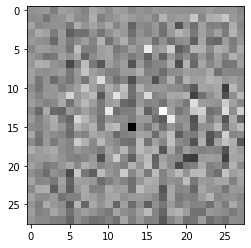

In [8]:
# 测试生成器能否生成图片
generator = make_generator_model()
# 设置生成噪声数据噪声数据
noise = tf.random.normal([1,100])
generated_image = generator(noise, training=False) #设置模型为未训练模式
 
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

##### 四、定义判别器D函数

In [10]:
# 定义判别器D函数，输入为28*28*1,输出为1*1，具体为图像的卷积分类过程
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
 
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
 
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
 
    return model

In [11]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [12]:
# 测试判别器的模型结构和输出结构
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00290049]], shape=(1, 1), dtype=float32)


##### 五、设置模型参数

In [13]:
# 定义判别器的损失函数
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss #总的loss
    return total_loss

In [14]:
# 定义生成器的损失函数
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [15]:
# 选择优化器，确定优化器的初始值
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [16]:
# 设置checkpoint的存放位置
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [17]:
# 设置训练批次和输入的噪声数据维度
EPOCHS = 40
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim]) #随机种子

##### 六、定义函数设置训练过程

In [18]:
# 定义训练模型
def train_step(images):
    # 生成噪声数据
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    # 使用梯度下降算法
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True) #生成的图片
 
        real_output = discriminator(images, training=True) #判别器对真实图片的判别结果D(x)
        fake_output = discriminator(generated_images, training=True) #判别器对生成图片的判别结果D(G(z))
 
        gen_loss = generator_loss(fake_output) #计算生成器损失函数loss()
        disc_loss = discriminator_loss(real_output, fake_output) #计算判别器损失函数loss()
 
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables) #计算生成器的梯度
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables) #计算判别器的梯度
 
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) #对生成器进行优化
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables)) #对判别器进行优化

In [19]:
# 定义总的训练过程
def train(dataset, epochs):
    for epoch in range(epochs): #总训练的次数
        start = time.time()
 
        for image_batch in dataset: #一次训练时训练所有的batch
            train_step(image_batch)
 
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                             epoch + 1,
                             seed)
 
    # 每 15 个 epoch 保存一次模型
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
 
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
 
  # 最后一个 epoch 结束后生成图片
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)

##### 七、保存生成的图像

In [22]:
# 设置图像的保存函数
def generate_and_save_images(model, epoch, test_input):
  # 注意 training` 设定为 False
  # 因此，所有层都在推理模式下运行（batchnorm）。
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

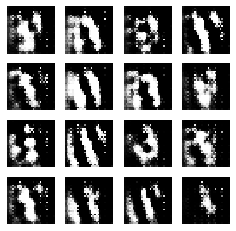

Time for epoch 4 is 748.3179471492767 sec


KeyboardInterrupt: 

In [23]:
train(train_dataset, EPOCHS)